# E-commerce Product recommendation
## Author github.com/tushar2704



E-commerce companies like AMazon , flipkart uses different recommendation systems to provide suggestions to the customers.Amazon uses currently item-item collaberrative filtering, which scales to massive datasets and produces high quality recommendation system in the real time. This system is a kind of a information filtering system which seeks to predict the "rating" or preferences which user is interested in.



# Introduction to Recommendation systems

In this modern world we are overloaded with data and this data provides us the useful information. But it's not possible for the user to extract the information which interest them from these data. In order to help the user to find out information about the product , recommedation systems where developed.

Recommeder system creates a similarity between the user and items and exploits the similarity between user/item to make recommendations.


What recommeder system can solve ?

1. It can help the user to find the right product.
2. It can increase the user engagement. For example, there's 40% more click on the google news due to recommendation.
3. It helps the item providers to deliver the items to the right user.In Amazon , 35 % products get sold due to recommendation.
4. It helps to make the contents more personalized.In Netflix most of the rented movies are from recommendations.


# Attribute Information:

● userId : Every user identified with a unique id

● productId : Every product identified with a unique id

● Rating : Rating of the corresponding product by the corresponding user

● timestamp : Time of the rating ( ignore this column for this exercise)



# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Load the Dataset and Add headers

In [ ]:
electronics_data = pd.read_excel(r'C:\content\ratings_Electronics.xlsx', sheet_name=1)



In [ ]:
# Display the data

electronics_data.head()


,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:

#Shape of the data
electronics_data.shape

(7824482, 4)

In [ ]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [ ]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [ ]:
electronics_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [ ]:
#Five point summary

electronics_data.describe()['Rating'].T


count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## Handling Missing values


In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())



Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


## Ratings

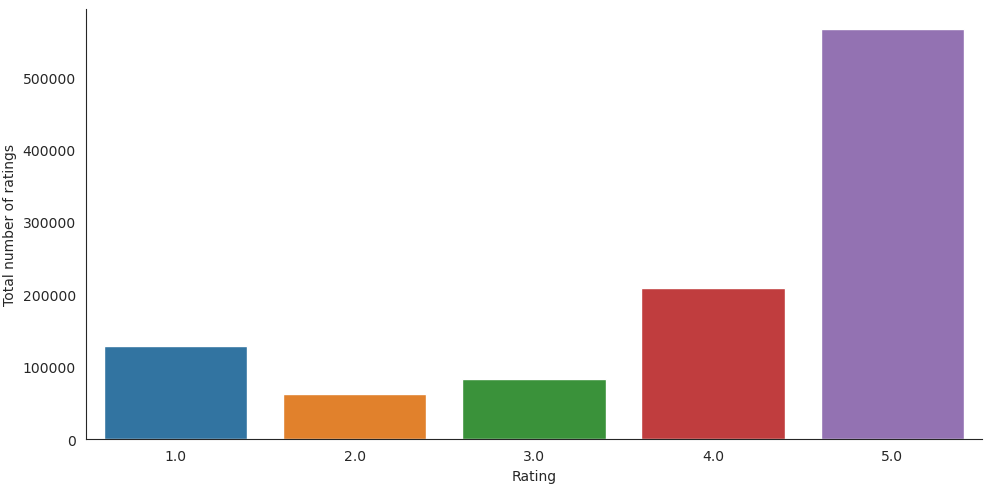

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="Rating", data=electronics_data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")


Most of the people has given the rating of 5

## Unique Users and products


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


## Dropping the TimeStamp Column

In [ ]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [ ]:
#Analysis of rating given by the user

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()


count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

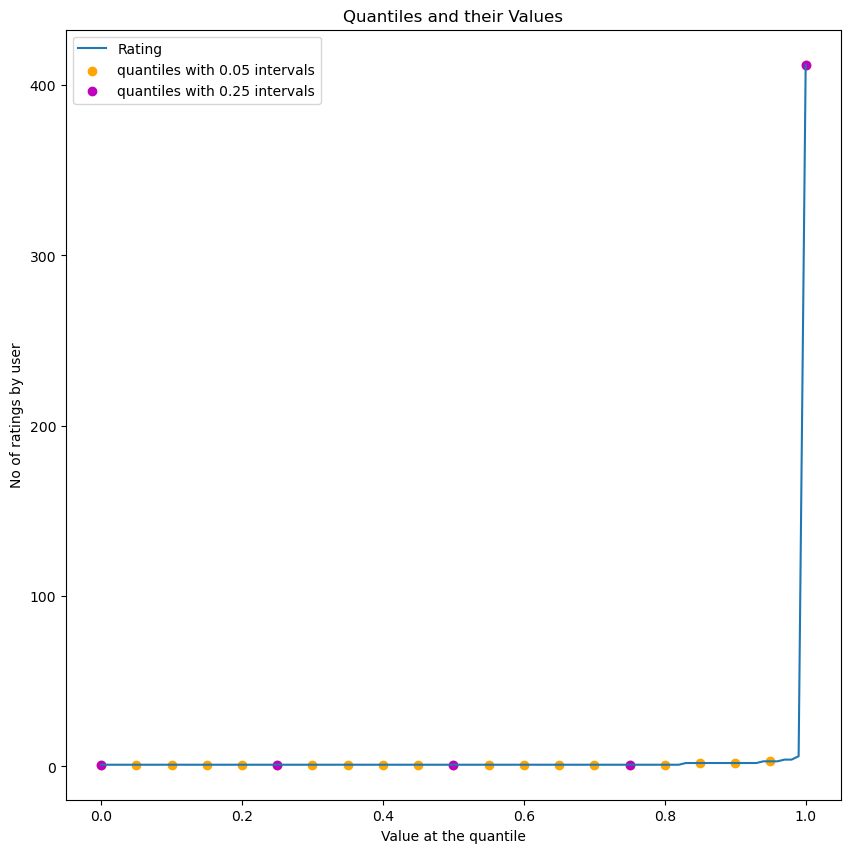

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 38



# Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

![image.png](attachment:image.png)

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

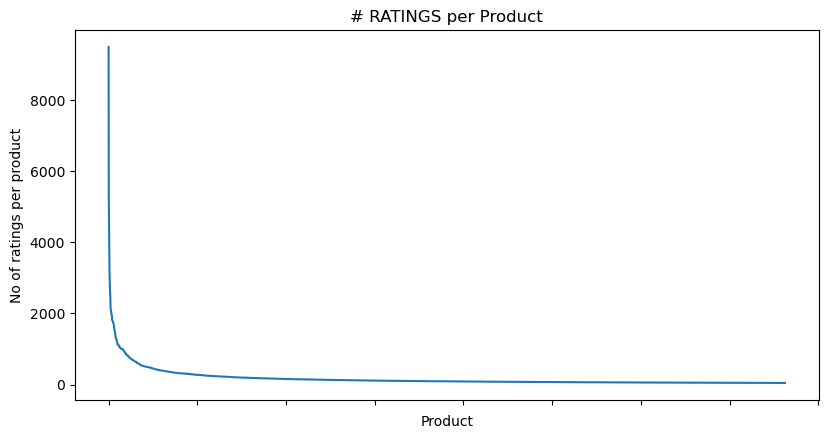

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
#Average rating of the product

new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()


productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [ ]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [ ]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [ ]:
ratings_mean_count['rating_counts'].max()


9487

<Figure size 800x600 with 0 Axes>

<Axes: >

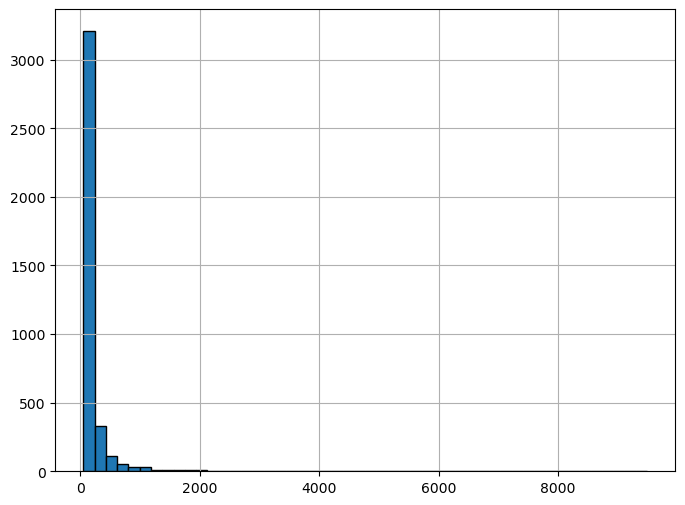

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

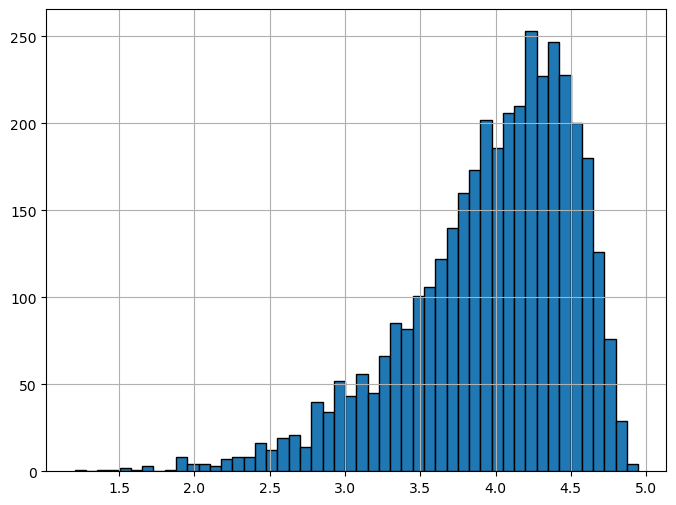

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

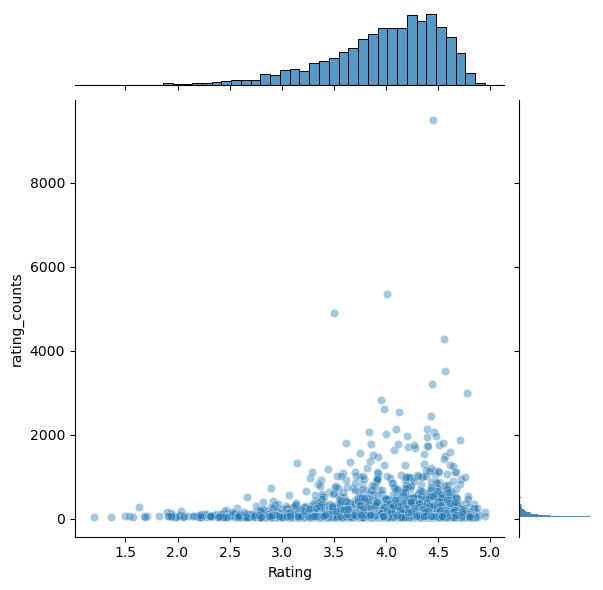

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='productId'>

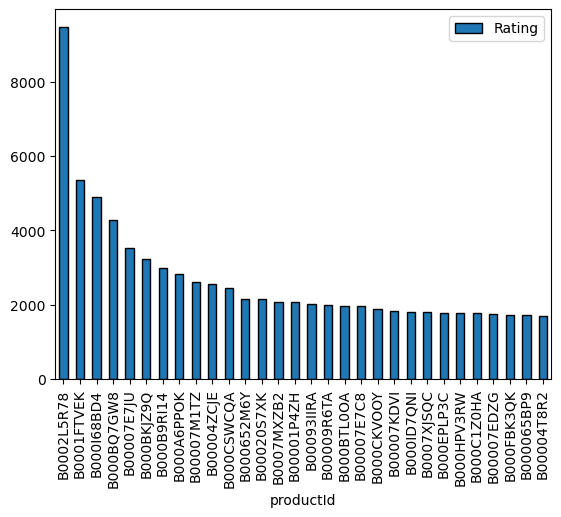

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [ ]:

new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [ ]:
ratings_matrix.shape


(9832, 76)

Transposing the matrix

In [ ]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape


(76, 9832)

Unique products in subset of data


In [ ]:
X1 = X


In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [ ]:
X.index[75]


'B00000K135'

Index # of product ID purchased by customer



In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 25 highly correlated products in sequence



In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:24]

['6301977173',
 '9575871979',
 '9985511476',
 'B000001OM5',
 'B00000J3UJ',
 'B00000J4EY',
 'B00000JBHP',
 'B00000JCT8',
 'B00000JCTO',
 'B00000JHWX',
 'B00000JII6']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.
